In [1]:
pip install spacy


In [2]:
pip install shifterator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 MB 7.3 MB/s eta 0:00:00


In [3]:
pip install -U benepar


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.7 MB/s eta 0:00:00
  Created wheel for benepar: filename=benepar-0.2.0-py3-none-any.whl size=37625 sha256=72a4bf7d6b8fb1c07ac3de8fe87aacf345b9436957a3d884c0d85d075510efd9
  Stored i

In [4]:
import os
import spacy
from collections import Counter
# import shifterator as sh
import matplotlib.pyplot as plt
import benepar as bnp
from benepar.spacy_plugin import BeneparComponent
from nltk.tree import Tree


/usr/local/lib/python3.11/dist-packages/benepar/spacy_plugin.py:7: FutureWarning: BeneparComponent and NonConstituentException have been moved to the benepar module. Use `from benepar import BeneparComponent, NonConstituentException` instead of benepar.spacy_plugin. The benepar.spacy_plugin namespace is deprecated and will be removed in a future version.
  warnings.warn(


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# benepar
import benepar
benepar.download('benepar_en3')

[nltk_data] Downloading package benepar_en3 to /root/nltk_data...
[nltk_data]   Unzipping models/benepar_en3.zip.


True

In [ ]:
# spacy model load
nlp = spacy.load("en_core_web_sm")

# benepar constituency parser addition (ERRORS SOMETIMES!!)
nlp.add_pipe("benepar", config = {'model': 'benepar_en3'})


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
pre_folder = '/content/drive/MyDrive/TFG/PRE_ELEC_SCRIPTS'
pre_files = [os.path.join(pre_folder, f) for f in os.listdir(pre_folder) if f.endswith('.txt')]

post_folder = '/content/drive/MyDrive/TFG/POST_ELEC_SCRIPTS'
post_files = [os.path.join(post_folder, f) for f in os.listdir(post_folder) if f.endswith('.txt')]

# Syntactical

## SUBJECTS

In [ ]:

nlp = spacy.load("en_core_web_sm")

#aux
def sub_getter(doc, sdict):
  for s in doc.sents:
    for token in s:
      if token.dep_ in ('nsubj', 'nsubjpass'):
        sdict[token.text] += 1

#main
def extract_subjects(file_list):
  s_con = Counter()

  for file in file_list:
    with open(file, 'r', encoding='utf-8') as f:
      text = f.read()
      text = text.lower()
      doc = nlp(text)

      sub_getter(doc, s_con)

      # for s in doc.sents:
      #   for token in s:
      #     if token.dep_ in ('nsubj', 'nsubjpass'):
      #       s_con[token.text] += 1

  return s_con

In [ ]:
pre_subjects = extract_subjects(pre_files)
post_subjects = extract_subjects(post_files)



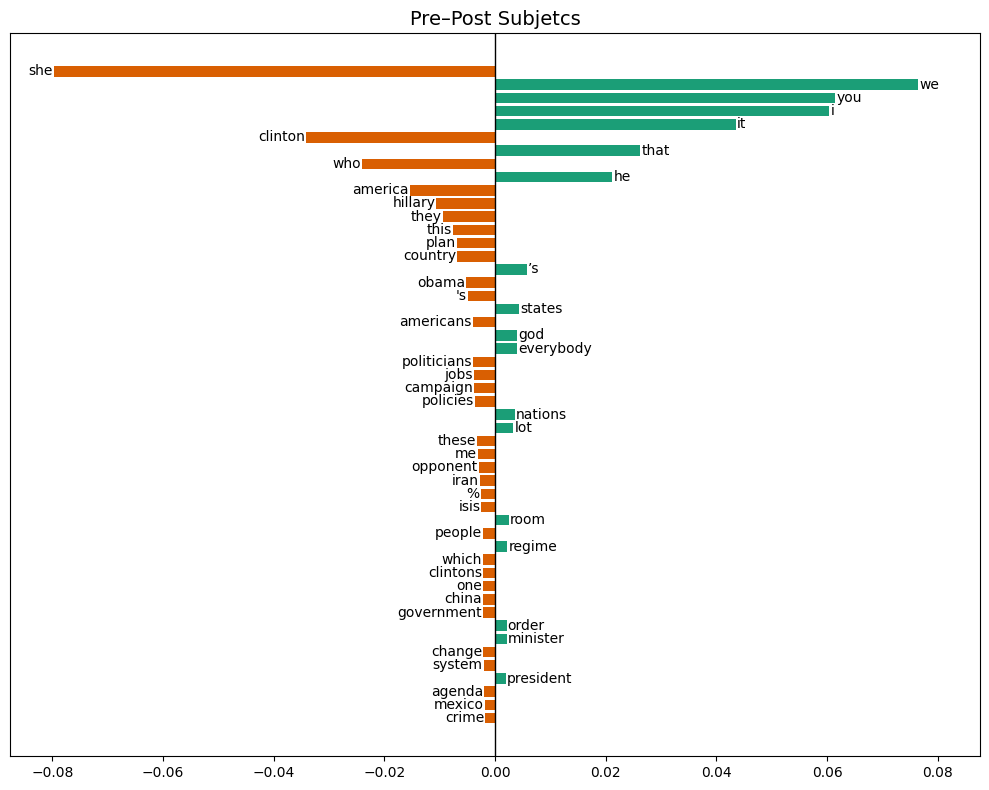

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from shifterator import shifts as rs

# Create shift object and get scores
shift = rs.ProportionShift(type2freq_1=pre_subjects, type2freq_2=post_subjects)
shift_scores = shift.get_shift_scores()
shift_df = pd.DataFrame(shift_scores.items(), columns=["word", "shift_score"])

# Select top N by absolute contribution
top_n = 50
shift_df = shift_df.reindex(shift_df['shift_score'].abs().sort_values(ascending=False).index)
shift_df = shift_df.head(top_n)
shift_df = shift_df[::-1].reset_index(drop=True)  # flip for plot order

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#d95f02' if x < 0 else '#1b9e77' for x in shift_df['shift_score']]
bars = ax.barh(shift_df.index, shift_df['shift_score'], color=colors)

# Annotate each bar at its endpoint
for i, (score, word) in enumerate(zip(shift_df['shift_score'], shift_df['word'])):
    if score < 0:
        ax.text(score - 0.0002, i, word, va='center', ha='right', fontsize=10)
    else:
        ax.text(score + 0.0002, i, word, va='center', ha='left', fontsize=10)

# Draw a fixed center line
ax.axvline(0, color='black', linewidth=1)

# Set symmetric x-axis limits to keep center line fixed
max_val = shift_df['shift_score'].abs().max()
ax.set_xlim(-max_val * 1.1, max_val * 1.1)  # Add 10% padding

# Clean up plot
ax.set_yticks([])
ax.set_title("Pre–Post Subjetcs", fontsize=14)
# ax.set_xlabel("Contribution to Shift", fontsize=12)

plt.tight_layout()
plt.show()


## SUBJECT VERB

In [ ]:
#sv
def sv_getter(doc, svdict):
  for s in doc.sents:
    for token in s:
      if token.dep_ in ('nsubj', 'nsubjpass') and token.head.pos_ == "VERB":
        sub = token.text
        verb = token.head.lemma_
        pair = f"{sub}/{verb}"
        svdict[pair] += 1


# SUBJECT-VERB PAIRS
def extract_sv_pairs(file_list):
  sv_con = Counter()

  for file in file_list:
    with open(file, 'r', encoding='utf-8') as f:
      text = f.read()
      text = text.lower()
      doc = nlp(text)

      sv_getter(doc, sv_con)

      # for s in doc.sents:
      #   for token in s:
      #     if token.dep_ in ('nsubj', 'nsubjpass') and token.head.pos_ == "VERB":
      #       sub = token.text
      #       verb = token.head.lemma_
      #       pair = f"{sub}/{verb}"
      #       sv_con[pair] += 1

  return sv_con

In [ ]:
# subject-verb pairs

pre_sv = extract_sv_pairs(pre_files)
post_sv = extract_sv_pairs(post_files)

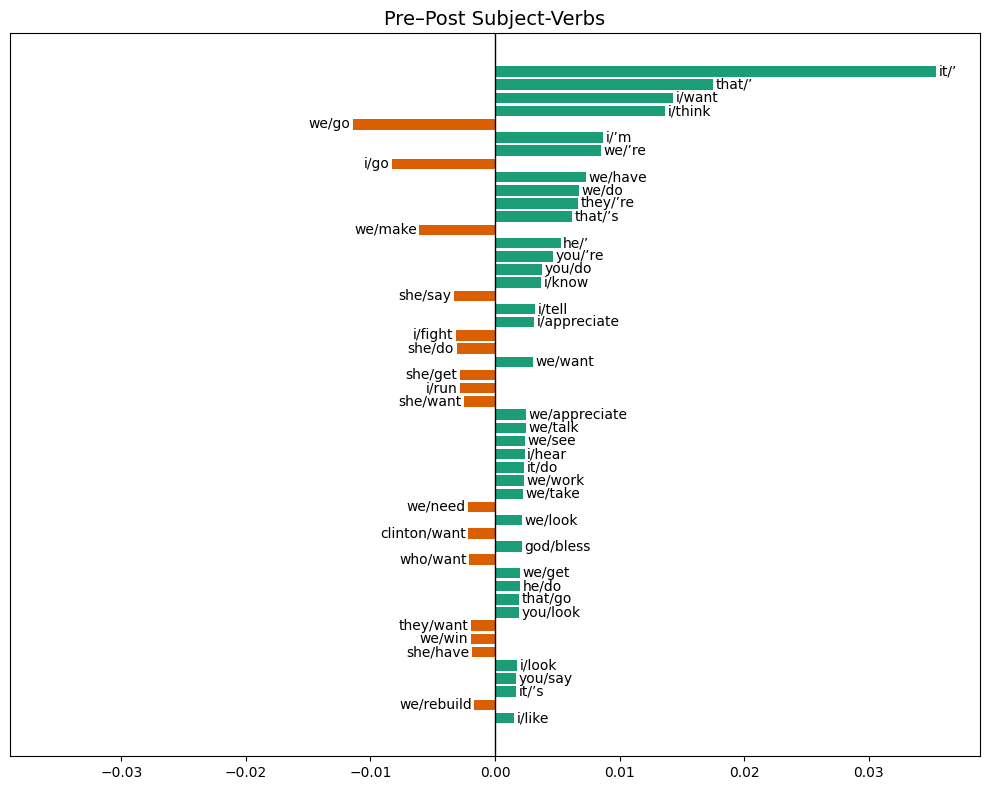

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from shifterator import shifts as rs

# Create shift object and get scores
shift = rs.ProportionShift(type2freq_1=pre_sv, type2freq_2=post_sv)
shift_scores = shift.get_shift_scores()
shift_df = pd.DataFrame(shift_scores.items(), columns=["word", "shift_score"])

# Select top N by absolute contribution
top_n = 50
shift_df = shift_df.reindex(shift_df['shift_score'].abs().sort_values(ascending=False).index)
shift_df = shift_df.head(top_n)
shift_df = shift_df[::-1].reset_index(drop=True)  # flip for plot order

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#d95f02' if x < 0 else '#1b9e77' for x in shift_df['shift_score']]
bars = ax.barh(shift_df.index, shift_df['shift_score'], color=colors)

# Annotate each bar at its endpoint
for i, (score, word) in enumerate(zip(shift_df['shift_score'], shift_df['word'])):
    if score < 0:
        ax.text(score - 0.0002, i, word, va='center', ha='right', fontsize=10)
    else:
        ax.text(score + 0.0002, i, word, va='center', ha='left', fontsize=10)

# Draw a fixed center line
ax.axvline(0, color='black', linewidth=1)

# Set symmetric x-axis limits to keep center line fixed
max_val = shift_df['shift_score'].abs().max()
ax.set_xlim(-max_val * 1.1, max_val * 1.1)  # Add 10% padding

# Clean up plot
ax.set_yticks([])
ax.set_title("Pre–Post Subject-Verbs", fontsize=14)
# ax.set_xlabel("Contribution to Shift", fontsize=12)

plt.tight_layout()
plt.show()


## Subject-Verb-Object

In [ ]:
#svo
def get_svo(doc, svo_dict):
  for s in doc.sents:
    for token in s:
      if token.dep_ in ('nsubj', 'nsubjpass') and token.head.pos_ == 'VERB':
        sub = token.text
        verb = token.head.lemma_
        obj = None

        for c in token.head.children:
          if c.dep_ in ('attr', 'prep', 'pobj', 'dobj'):
            obj = c.text
            break

        if obj:
          trip = f"{sub}/{verb}/{obj}"
          svo_dict[trip] += 1


# SUBJ-VERB-OBJ
def extract_svo(file_list):
  svo_con = Counter()

  for file in file_list:
    with open(file, 'r', encoding='utf-8') as f:
      text = f.read()
      text = text.lower()
      doc = nlp(text)

      get_svo(doc, svo_con)

  return svo_con

In [ ]:
pre_svo = extract_svo(pre_files)
post_svo = extract_svo(post_files)

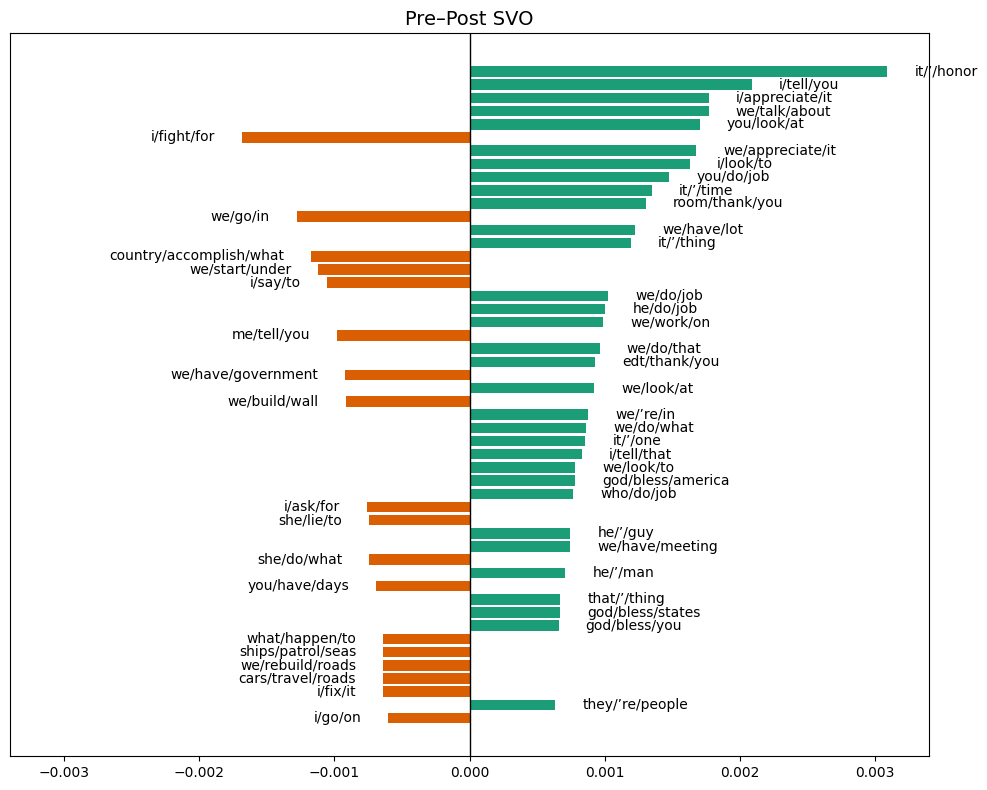

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from shifterator import shifts as rs

# Create shift object and get scores
shift = rs.ProportionShift(type2freq_1=pre_svo, type2freq_2=post_svo)
shift_scores = shift.get_shift_scores()
shift_df = pd.DataFrame(shift_scores.items(), columns=["word", "shift_score"])

# Select top N by absolute contribution
top_n = 50
shift_df = shift_df.reindex(shift_df['shift_score'].abs().sort_values(ascending=False).index)
shift_df = shift_df.head(top_n)
shift_df = shift_df[::-1].reset_index(drop=True)  # flip for plot order

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#d95f02' if x < 0 else '#1b9e77' for x in shift_df['shift_score']]
bars = ax.barh(shift_df.index, shift_df['shift_score'], color=colors)

# Annotate each bar at its endpoint
for i, (score, word) in enumerate(zip(shift_df['shift_score'], shift_df['word'])):
    if score < 0:
        ax.text(score - 0.0002, i, word, va='center', ha='right', fontsize=10)
    else:
        ax.text(score + 0.0002, i, word, va='center', ha='left', fontsize=10)

# Draw a fixed center line
ax.axvline(0, color='black', linewidth=1)

# Set symmetric x-axis limits to keep center line fixed
max_val = shift_df['shift_score'].abs().max()
ax.set_xlim(-max_val * 1.1, max_val * 1.1)  # Add 10% padding

# Clean up plot
ax.set_yticks([])
ax.set_title("Pre–Post SVO", fontsize=14)
# ax.set_xlabel("Contribution to Shift", fontsize=12)

plt.tight_layout()
plt.show()


## COMP SV

ignoring the single-worded subjects for this shift


In [ ]:
#comps
def get_comps(token):
  sub_parts = [token.text]

  for c in token.lefts:
    if c.dep_ == 'det':  # Determiner first
      sub_parts.insert(0, c.text)

    elif c.dep_ in ('amod', 'poss', 'compound'):
      sub_parts.insert(1, c.text)

  for c in token.children:
    if c.dep in ('conj', 'cc'):
      sub_parts.append(c.text)

  if len(sub_parts) == 1:
    return None  # Ignore single-word subjects

  return " ".join(sub_parts)


#comp sv
def csv_getter(doc, csvdict):
  for s in doc.sents:
    for token in s:
      if token.dep_ in ('nsubj', 'nsubjpass') and token.head.pos_ == "VERB":
        sub = get_comps(token)
        if sub != None:
          verb = token.head.lemma_
          pair = f"{sub}/{verb}"
          csvdict[pair] += 1


# COMPOUND SUBJECT-VERB PAIRS
def extract_csv(file_list):
  csv_con = Counter()

  for file in file_list:
    with open(file, 'r', encoding='utf-8') as f:
      text = f.read()
      text = text.lower()
      doc = nlp(text)

      csv_getter(doc, csv_con)

  return csv_con


In [ ]:
# Compound SV pairs

pre_csv = extract_csv(pre_files)
post_csv = extract_csv(post_files)

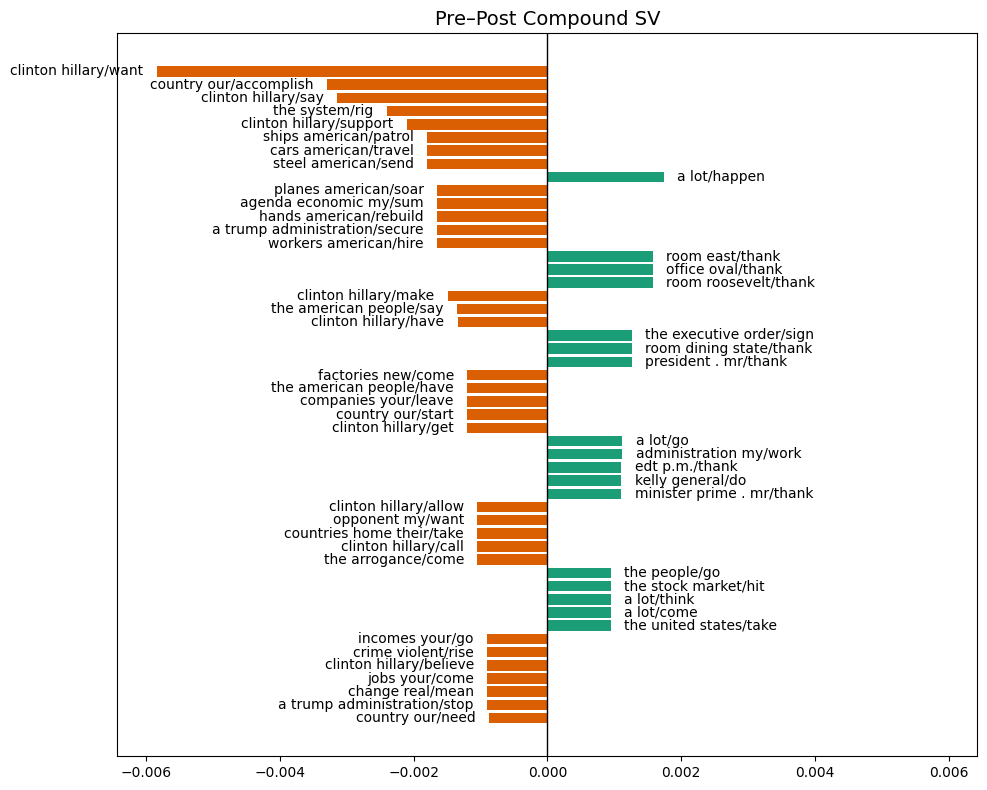

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from shifterator import shifts as rs

# Create shift object and get scores
shift = rs.ProportionShift(type2freq_1=pre_csv, type2freq_2=post_csv)
shift_scores = shift.get_shift_scores()
shift_df = pd.DataFrame(shift_scores.items(), columns=["word", "shift_score"])

# Select top N by absolute contribution
top_n = 50
shift_df = shift_df.reindex(shift_df['shift_score'].abs().sort_values(ascending=False).index)
shift_df = shift_df.head(top_n)
shift_df = shift_df[::-1].reset_index(drop=True)  # flip for plot order

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#d95f02' if x < 0 else '#1b9e77' for x in shift_df['shift_score']]
bars = ax.barh(shift_df.index, shift_df['shift_score'], color=colors)

# Annotate each bar at its endpoint
for i, (score, word) in enumerate(zip(shift_df['shift_score'], shift_df['word'])):
    if score < 0:
        ax.text(score - 0.0002, i, word, va='center', ha='right', fontsize=10)
    else:
        ax.text(score + 0.0002, i, word, va='center', ha='left', fontsize=10)

# Draw a fixed center line
ax.axvline(0, color='black', linewidth=1)

# Set symmetric x-axis limits to keep center line fixed
max_val = shift_df['shift_score'].abs().max()
ax.set_xlim(-max_val * 1.1, max_val * 1.1)  # Add 10% padding

# Clean up plot
ax.set_yticks([])
ax.set_title("Pre–Post Compound SV", fontsize=14)
# ax.set_xlabel("Contribution to Shift", fontsize=12)

plt.tight_layout()
plt.show()


## Subject-ADJ (continued in constituency)

In [ ]:
def whole_subber(token):
  parts = [token.text]

  for c in token.lefts:
    if c.dep_ in ('amod', 'poss', 'compound'):
      parts.insert(0, c.text)

  sub = " ".join(parts)
  return sub if len(parts) > 1 else None

#sa
def sa_getter(doc, sadict):
  for s in doc.sents:
    for token in s:
      if token.pos_ in ('NOUN', 'PROPN'):
        full_sub = whole_subber(token)
        if full_sub:
          sadict[full_sub] += 1


# SUBJECT-ADJ PAIRS
def extract_sa_pairs(file_list):
  sa_con = Counter()

  for file in file_list:
    with open(file, 'r', encoding='utf-8') as f:
      text = f.read()
      text = text.lower()
      doc = nlp(text)

      sa_getter(doc, sa_con)

  return sa_con

In [ ]:
pre_sa = extract_sa_pairs(pre_files)
post_sa = extract_sa_pairs(post_files)

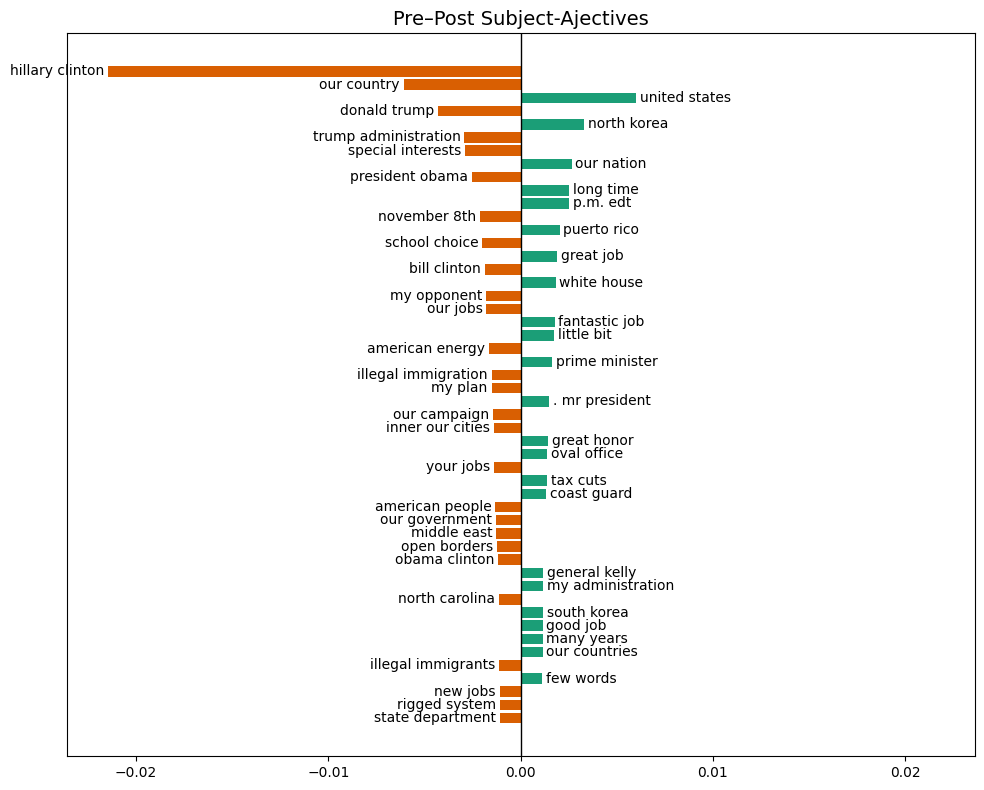

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from shifterator import shifts as rs

# Create shift object and get scores
shift = rs.ProportionShift(type2freq_1=pre_sa, type2freq_2=post_sa)
shift_scores = shift.get_shift_scores()
shift_df = pd.DataFrame(shift_scores.items(), columns=["word", "shift_score"])

# Select top N by absolute contribution
top_n = 50
shift_df = shift_df.reindex(shift_df['shift_score'].abs().sort_values(ascending=False).index)
shift_df = shift_df.head(top_n)
shift_df = shift_df[::-1].reset_index(drop=True)  # flip for plot order

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#d95f02' if x < 0 else '#1b9e77' for x in shift_df['shift_score']]
bars = ax.barh(shift_df.index, shift_df['shift_score'], color=colors)

# Annotate each bar at its endpoint
for i, (score, word) in enumerate(zip(shift_df['shift_score'], shift_df['word'])):
    if score < 0:
        ax.text(score - 0.0002, i, word, va='center', ha='right', fontsize=10)
    else:
        ax.text(score + 0.0002, i, word, va='center', ha='left', fontsize=10)

# Draw a fixed center line
ax.axvline(0, color='black', linewidth=1)

# Set symmetric x-axis limits to keep center line fixed
max_val = shift_df['shift_score'].abs().max()
ax.set_xlim(-max_val * 1.1, max_val * 1.1)  # Add 10% padding

# Clean up plot
ax.set_yticks([])
ax.set_title("Pre–Post Subject-Adjectives", fontsize=14)
# ax.set_xlabel("Contribution to Shift", fontsize=12)

plt.tight_layout()
plt.show()


## Separate plots for frequency: Subs and SV

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_subjects(subj_counter, title="Top Subjects", top_n=15):
  top_subs = subj_counter.most_common(top_n)
  subs, freqs =  zip(*top_subs)

  plt.figure(figsize=(8,6))
  sns.barplot(x=list(subs), y=list(freqs), width=0.6)
  plt.xticks(rotation=45)
  plt.title(title)
  plt.xlabel('Subjects')
  plt.ylabel('Frequencies')
  plt.tight_layout()
  plt.show()

In [ ]:
plot_top_subjects(pre_subjects, title='Top Subjects Pre-Elec')
plot_top_subjects(post_subjects, title='Top Subjects Post-Elec')

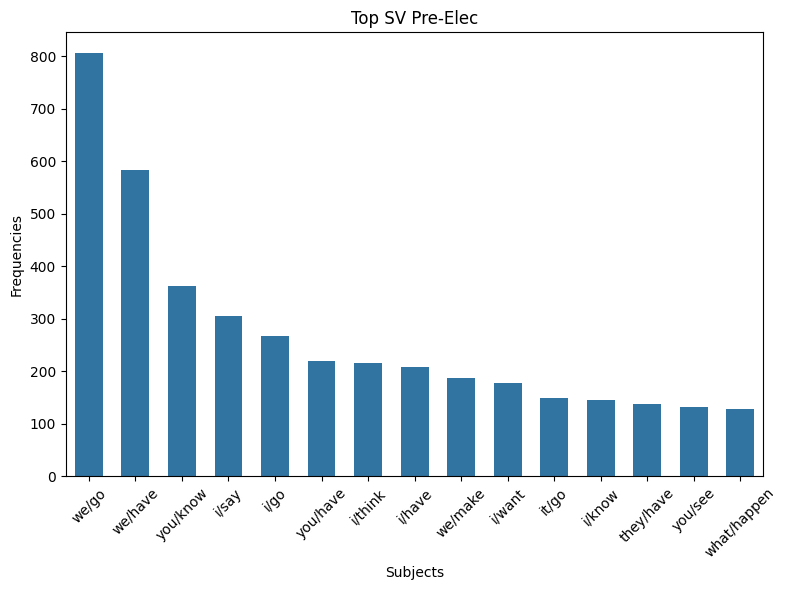

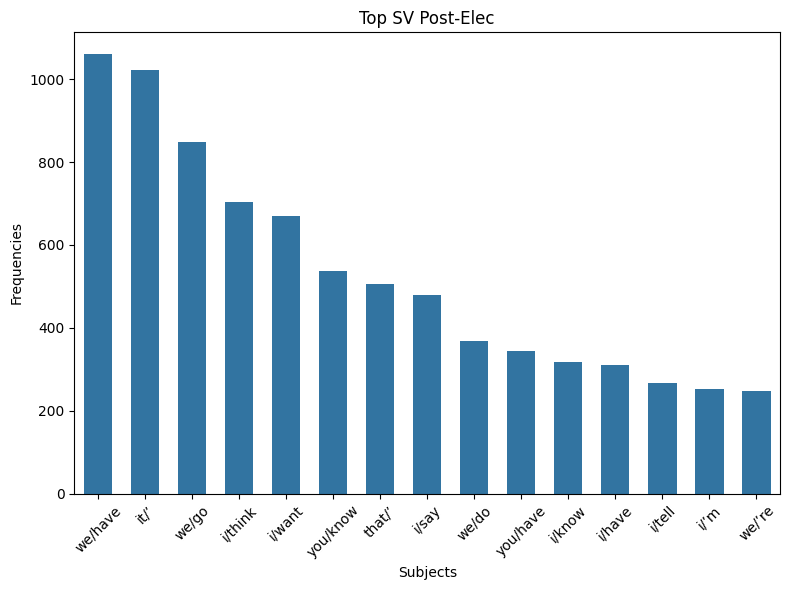

In [ ]:
plot_top_subjects(pre_sv, title='Top SV Pre-Elec')
plot_top_subjects(post_sv, title='Top SV Post-Elec')